In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# tensorflow RNG
# tf.random.set_seed(seed)

In [3]:
data_path = Path("/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/CSV")

In [4]:
model_path=Path("./models")

In [46]:
train_csv = pd.read_csv(data_path/"train_small.csv", usecols=['document_type', 'body'])
val_csv = pd.read_csv(data_path/"validation_small.csv", usecols=['document_type', 'body'])
test_csv = pd.read_csv(data_path/"test_small.csv", usecols=['document_type', 'body'])

In [47]:
train_csv["is_valid"] = False
val_csv["is_valid"] = True
data = pd.concat([train_csv, val_csv]); data.head()

,document_type,body,is_valid
0,outros,"{""tribunal justiça estado bahia poder judiciário salvador juizado cível defesa consumidor universo matutino projudi acm campus universidade salgado oliveira universo pituba salvador processo parte autora nailton lantyer cordeiro araujo parte atlantico fundo investimento direitos creditorios despacho vistos etc indefiro requerido pela parte demandante aguarde a sessão conciliação designada salvador de julho paulo alberto nunes chenaud juiz direito documento assinado eletronicamente""}",False
1,outros,"{""excelentíssimo senhor doutor juiz direito juizado cível defesa consumidor universo comarca salvador autos processo º atlântico fundo investimento direitos creditórios não padronizados nova denominação crdg fundo investimento direitos creditórios não padronizados empresa inscrita cnpj sob º com sede av brigadeiro faria lima andar são paulo por seus advogados signatários nos autos ação epígrafe proposta por nailton lantyer cordeiro araujo vem respeitosamente presença vossa excelência inconformado com r sentença fls com fulcro ARTIGO_41 lei º interpor presente recurso inominado ser recebido...",False
2,outros,"{""razões recurso inominado recorrente atlantico fundo investimento direitos creditórios não padronizados recorrido nailton lantyer cordeiro araujo autos processo º origem jec comarca salvador colendo colégio recursal ilustres julgadores síntese demanda parte recorrida intentou presente demanda alegando síntese que teve seu nome indevidamente incluído cadastro proteção crédito que diligenciar sentido obter informações acerca inscrição verificou que negativação foi ordenada pelo recorrente sendo assim propôs presente demanda pleiteando exclusão seus dados spc serasa inexigibilidade débito o ...",False
3,outros,"{""empresa recorrente tornou credora dos débitos nome parte recorrida referente uma linha telefônica razão contrato cessão crédito entre empresa originalmente credora cedente o atlântico fundo investimentos direitos creditórios não padronizados ora cessionária com efeito caso não houve qualquer cobrança indevida afinal tornando a parte recorrida inadimplente vindo parte recorrente firmar contrato cessão direitos creditórios junto empresa credora recorrido totalmente legítima cobrança perpetrada cumpre esclarecer que época cessão parte recorrida estava inadimplente com empresa recorrente mot...",False
4,outros,"{""entretanto verdade parte apelante tornou titular crédito devido pela parte apelada por força um contrato cessão crédito celebrado com brasil telecom a seja que pese parte apelada não ter firmado inicialmente contrato diretamente junto apelante este tornou seu credor virtude aludido instrumento cessão crédito portanto caso seja comprovada alegação perpetrada pela parte apelada que o contrato que originou seu débito seja fraudulento quem deverá arcar com eventuais ônus a brasil telecom a não esta parte apelante que não foi quem contratou com parte apelada por sua vez parte apelada foi regu...",False


In [ ]:
# dls_lm = TextDataLoaders.from_df(data, seed=seed, is_lm=True, text_col="body",
#                                  valid_col="is_valid", tok_tfm=Tokenizer.from_df('body', tok=tok))

In [ ]:
dls_lm = DataBlock(
    blocks=(TextBlock.from_df('body', tok=SentencePieceTokenizer(), is_lm=True)),
    get_x=ColReader('text'), splitter=ColSplitter()).dataloaders(data)

In [ ]:
dls_lm.vocab[:15], len(dls_lm.vocab)

In [ ]:
assert len(train_csv) == len(dls_lm.train_ds) and len(val_csv) ==len(dls_lm.valid_ds)

In [ ]:
torch.save(dls_lm, "./data/dls_lm.pth")

In [5]:
dls_lm = torch.load("./data/dls_lm.pth")

In [ ]:
dls_lm.show_batch()

In [32]:
perplexity = Perplexity()
f1 = F1Score(average='macro')

In [ ]:
# config = awd_qrnn_lm_config.copy()
# config['n_hid'] = 1550 #default 1152
# config['n_layers'] = 4 #default 3

In [ ]:
# lm_fns3 = ['pt_wt_sp15_multifit', 'pt_wt_vocab_sp15_multifit']
# lm_fns3_bwd = ['pt_wt_sp15_multifit_bwd', 'pt_wt_vocab_sp15_multifit_bwd']

In [ ]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, path=Path("."), drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [ ]:
learn_lm.save_encoder("no_fine_tune_enc")

In [ ]:
TEXT = "O Ministro"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

In [ ]:
learn_lm.freeze()
learn_lm.summary()

In [ ]:
learn_lm.lr_find()

In [ ]:
learn_lm.fit_one_cycle(1, 1e-1)

In [ ]:
learn_lm.recorder.plot_loss()

In [ ]:
learn_lm.save('lstm_lm_1E')

In [10]:
learn_lm.load("lstm_lm_1E")

In [11]:
learn_lm.unfreeze()

In [12]:
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  True      
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  True      
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  True      
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

In [ ]:
learn_lm.lr_find()

In [13]:
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,2.966244,2.813701,0.443039,0.556961,16.671509,44:03
1,2.675253,2.457869,0.384936,0.615065,11.679898,34:06
2,2.611775,2.390572,0.373849,0.626151,10.919739,33:42


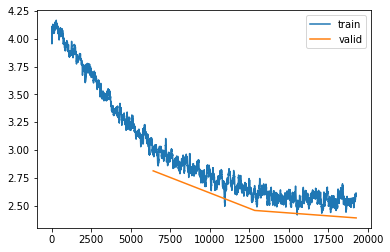

In [14]:
learn_lm.recorder.plot_loss()

In [15]:
learn_lm.save('lstm_lm_1E+3E')

Path('models/lstm_lm_1E+3E.pth')

In [16]:
learn_lm.save_encoder('lstm_lm_1E+3E_enc')

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=8.31763736641733e-06)

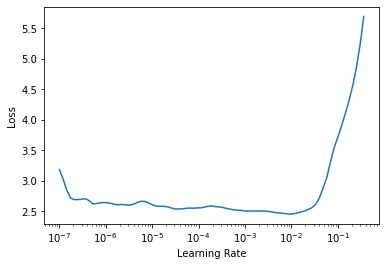

In [20]:
learn_lm.lr_find()

In [21]:
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,2.454777,2.338836,0.366251,0.633750,10.369164,33:51
1,2.371338,2.217347,0.348005,0.651997,9.182940,1:48:11
2,2.265793,2.180504,0.342098,0.657903,8.850764,2:10:31


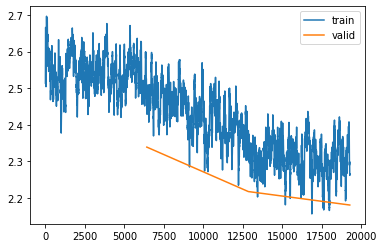

In [22]:
learn_lm.recorder.plot_loss()

In [23]:
learn_lm.save('lstm_lm_1E+3E+3E')

Path('models/lstm_lm_1E+3E+3E.pth')

In [24]:
learn_lm.save_encoder('lstm_lm_1E+3E+3E_enc')

In [25]:
TEXT = "O Ministro"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [26]:
print("\n".join(preds))

▁xxbos ▁o xxunk ▁ministro ▁luiz ▁fux ▁relator ▁decisão ▁que ▁possibilita ▁julgamento ▁recurso ▁presente ▁recurso ▁extraordinário ▁razão ▁pela ▁qual ▁requer ▁seja ▁admitido ▁recurso ▁extraordinário ▁interposto ▁para ▁reformar ▁acórdão ▁proferido ▁pela ▁turma ▁recursal ▁dos ▁juizados ▁especiais ▁federais ▁pernambuco ▁que ▁negou ▁provimento ▁recurso ▁inominado ▁interposto ▁pela ▁parte
▁xxbos ▁o xxunk ▁ministro ▁estado ▁previdência ▁social ▁seu ▁xxup ▁artigo _201 o ▁dispõe ▁sobre ▁regime ▁geral ▁previdência ▁social ▁os ▁seguintes ▁critérios ▁xxup ▁artigo _201 ▁previdência ▁social ▁será ▁organizada ▁sob ▁forma ▁regime ▁geral ▁caráter ▁contributivo ▁de ▁filiação ▁obrigatória ▁observados ▁critérios ▁que ▁preservem ▁equilíbrio ▁financeiro ▁atuarial


In [ ]:
dls_lm_bwd = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls_lm.tobackwards=_lm=True, backwards=True)),
    get_x=ColReader('text'), splitter=ColSplitter()).dataloaders(data)

In [7]:
assert dls_lm.vocab == dls_lm_bwd.vocab

In [8]:
del(dls_lm)

In [ ]:
torch.save(dls_lm_bwd, "./data/dls_lm_bwd.pth")

In [8]:
dls_lm_bwd = torch.load("./data/dls_lm_bwd.pth")

In [10]:
dls_lm_bwd.show_batch()

,text,text_
0,"""} ▁código ▁seguinte ▁com ▁site ▁xxup ▁validada ▁ser ▁pode ▁certidão ▁esta ▁gerada ▁certidão ▁eletrônico ▁documento ▁inicial ▁processamento ▁coordenadoria ▁maio ▁de brasília ▁{"" ▁xxbos ""} ▁impõe ▁que ▁medida ▁pedido ▁procedência ▁discutida ▁verba ▁indenizatória ▁natureza ▁diante ▁logo ▁renda ▁imposto ▁cálculo ▁base ▁correlato ▁valor ▁dedução ▁direito ▁possuem ▁contribuintes ▁que ▁modo ▁patrimonial ▁acréscimo ▁configura ▁não ▁plano ▁déficit ▁razão ▁instituída ▁extraordinária ▁contribuição ▁título ▁social ▁seguridade ▁banrisul ▁fundação ▁pago ▁valor ▁perdida ▁foi ▁que ▁parcela ▁recomposição ▁mera ▁mas ▁matemática","▁código ▁seguinte ▁com ▁site ▁xxup ▁validada ▁ser ▁pode ▁certidão ▁esta ▁gerada ▁certidão ▁eletrônico ▁documento ▁inicial ▁processamento ▁coordenadoria ▁maio ▁de brasília ▁{"" ▁xxbos ""} ▁impõe ▁que ▁medida ▁pedido ▁procedência ▁discutida ▁verba ▁indenizatória ▁natureza ▁diante ▁logo ▁renda ▁imposto ▁cálculo ▁base ▁correlato ▁valor ▁dedução ▁direito ▁possuem ▁contribuintes ▁que ▁modo ▁patrimonial ▁acréscimo ▁configura ▁não ▁plano ▁déficit ▁razão ▁instituída ▁extraordinária ▁contribuição ▁título ▁social ▁seguridade ▁banrisul ▁fundação ▁pago ▁valor ▁perdida ▁foi ▁que ▁parcela ▁recomposição ▁mera ▁mas ▁matemática ▁reserva"
1,▁nos ▁trabalhadores ▁dos ▁habitual ▁ganho ▁constitui ▁mesma ▁que ▁natalina ▁gratificação ▁sobre ▁previdenciária ▁contribuição ▁incide ▁que ▁considerando ▁nosso ▁grifo mani ▁sor e ▁alexandr ▁convocado ▁juiz ▁relator ▁data ▁fonte ▁citação ▁teor ▁inteiro ▁região ▁federal ▁regional ▁tribunal ▁seção ▁julgador ▁orgão ▁decisão ▁data ▁uf ▁processo ▁cível ▁apelação ▁classe ▁procedente ▁parcialmente ▁autora ▁parte ▁apelação ▁pertence ▁sepúlveda ▁min ▁stf ▁condicional ▁judicial ▁título ▁sentença ▁torna _1060 ▁lei ▁xxup _11 ▁artigo ▁xxup ▁nos ▁disposto ▁aplicação ▁que ▁decidiu ▁stf ▁e ▁pois,▁trabalhadores ▁dos ▁habitual ▁ganho ▁constitui ▁mesma ▁que ▁natalina ▁gratificação ▁sobre ▁previdenciária ▁contribuição ▁incide ▁que ▁considerando ▁nosso ▁grifo mani ▁sor e ▁alexandr ▁convocado ▁juiz ▁relator ▁data ▁fonte ▁citação ▁teor ▁inteiro ▁região ▁federal ▁regional ▁tribunal ▁seção ▁julgador ▁orgão ▁decisão ▁data ▁uf ▁processo ▁cível ▁apelação ▁classe ▁procedente ▁parcialmente ▁autora ▁parte ▁apelação ▁pertence ▁sepúlveda ▁min ▁stf ▁condicional ▁judicial ▁título ▁sentença ▁torna _1060 ▁lei ▁xxup _11 ▁artigo ▁xxup ▁nos ▁disposto ▁aplicação ▁que ▁decidiu ▁stf ▁e ▁pois ▁sucumbência
2,▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁parte ▁reforma ▁súmula raschi ▁b cio ▁clé ▁federal ▁juiz ▁relator ▁silva ▁batista ▁adriano o ▁recd ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto ▁recte ▁aprendiz ▁aluno ▁serv ▁tempo ▁cômputo ▁averb ▁prestações ▁relativas ▁diversas ▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁mantém ▁súmula ecato ▁c ▁reina ilton ▁u ▁federal ▁juiz ▁relator ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto o ▁recd ▁barroso,▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁parte ▁reforma ▁súmula raschi ▁b cio ▁clé ▁federal ▁juiz ▁relator ▁silva ▁batista ▁adriano o ▁recd ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto ▁recte ▁aprendiz ▁aluno ▁serv ▁tempo ▁cômputo ▁averb ▁prestações ▁relativas ▁diversas ▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁mantém ▁súmula ecato ▁c ▁reina ilton ▁u ▁federal ▁juiz ▁relator ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto o ▁recd ▁barroso a
3,"▁decisão ▁que ▁admitir ▁implicará ▁jurisdicional ▁exame ▁trazido ▁jurídico ▁argumento ▁sólido ▁como ▁acolher ▁instância ▁última ▁de ▁recorrida ▁decisão ▁conseqüência ▁processo ▁neste ▁exame ▁trazido ▁dico ▁jurí ▁argumento ▁acolhido ▁examinado ▁tenha ▁que ▁judiciária ▁seção ▁seja ▁que ▁qualquer ▁federais ▁especiais ▁juizados ▁dos ▁recursal ▁turma ▁mento ▁pronuncia ▁não ▁conhecer ▁autora ▁parte ▁dado ▁onde ▁até ▁associados ▁advogados ▁silva ▁ivo o anild ▁{"" ▁xxbos ""} ▁nacional ▁fazenda ▁procurador ▁s

In [11]:
learn_lm = language_model_learner(dls_lm_bwd, AWD_LSTM, path=Path("."), drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [12]:
learn_lm.freeze()
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=0.0691830962896347)

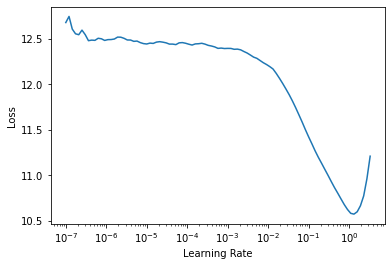

In [13]:
learn_lm.lr_find()

In [14]:
learn_lm.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.280356,3.839558,0.587987,0.412012,46.504898,34:48


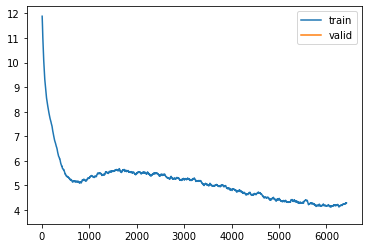

In [15]:
learn_lm.recorder.plot_loss()

In [16]:
learn_lm.save('lstm_lm_1E_bwd')

Path('models/lstm_lm_1E_bwd.pth')

In [ ]:
learn_lm.load("lstm_lm_1E_bwd")

In [17]:
learn_lm.unfreeze()

In [18]:
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  True      
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  True      
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  True      
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.2908675418875646e-06)

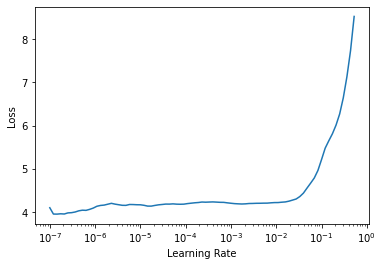

In [19]:
learn_lm.lr_find()

In [21]:
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.064942,2.808604,0.436870,0.563130,16.586742,36:38
1,2.674922,2.457955,0.380191,0.619809,11.680904,38:53
2,2.495064,2.391142,0.369993,0.630008,10.925968,40:58


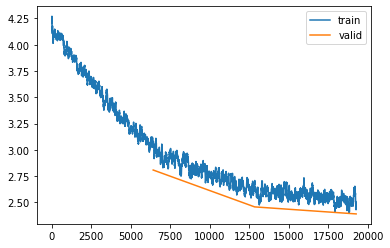

In [22]:
learn_lm.recorder.plot_loss()

In [23]:
learn_lm.save('lstm_lm_1E+3E_bwd')

Path('models/lstm_lm_1E+3E_bwd.pth')

In [24]:
learn_lm.save_encoder('lstm_lm_1E+3E_enc_bwd')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.0063095735386013985)

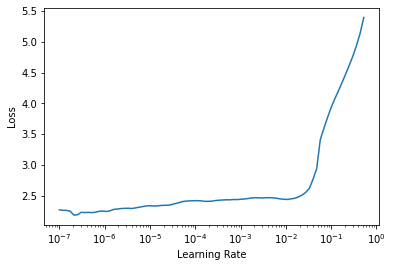

In [25]:
learn_lm.lr_find()

In [26]:
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,2.528972,2.336559,0.362176,0.637825,10.345572,35:43
1,2.352913,2.218098,0.344520,0.655481,9.189833,42:00
2,2.255635,2.180773,0.338580,0.661420,8.853151,35:39


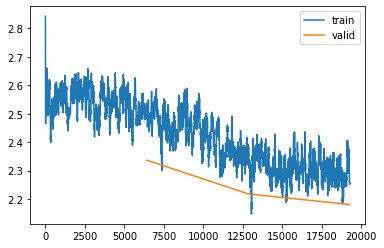

In [27]:
learn_lm.recorder.plot_loss()

In [28]:
learn_lm.save('lstm_lm_1E+3E+3E_bwd')

Path('models/lstm_lm_1E+3E+3E_bwd.pth')

In [29]:
learn_lm.save_encoder('lstm_lm_1E+3E+3E_enc_bwd')

In [9]:
dls = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls_lm_bwd.tok),  CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('document_type'), splitter=ColSplitter()).dataloaders(data)

/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
assert dls.vocab[0] == dls_lm_bwd.vocab

In [11]:
del(dls_lm_bwd)

In [12]:
torch.save(dls, "./data/dls.pth")

In [ ]:
dls = torch.load("./data/dls.pth")

In [10]:
n_samples = len(dls.train_ds); n_samples

149217

In [28]:
class_counts = torch.bincount(torch.stack(list(dls.train_ds.tls[1][:])))

In [29]:
class_weights = n_samples / (dls.c * class_counts); class_weights

TensorCategory([44.9720,  9.7681, 71.8772,  0.1854,  2.6154, 11.6813])

In [30]:
class_weights = torch.FloatTensor(class_weights).cuda(); class_weights

tensor([44.9720,  9.7681, 71.8772,  0.1854,  2.6154, 11.6813], device='cuda:0')

In [33]:
learn = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                loss_func=CrossEntropyLossFlat(weight=class_weights),
                                metrics=[accuracy, f1])

In [34]:
learn.load_encoder("lstm_lm_1E+3E+3E_enc")

In [35]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=2.2908675418875646e-06)

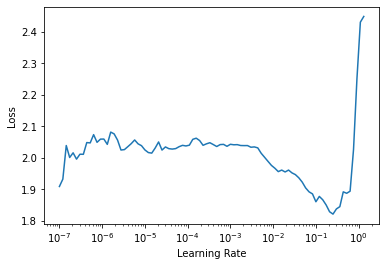

In [37]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.961801,0.864121,0.610271,0.298024,07:35


In [39]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.695018,0.644269,0.688901,0.368934,12:21


In [40]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.498383,0.598076,0.711680,0.404785,18:18


In [41]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.435686,0.570500,0.758579,0.449526,19:18
1,0.484861,0.559896,0.765198,0.440880,12:41


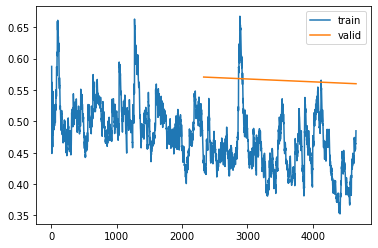

In [42]:
learn.recorder.plot_loss()

In [43]:
learn.save('fwd_clf')

Path('models/fwd_clf.pth')

In [ ]:
learn.load("fwd_clf")

In [ ]:
dls_bwd = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls.tok, backwards=True),  CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('document_type'), splitter=ColSplitter()).dataloaders(data)

In [ ]:
assert dls.vocab[0] == dls_bwd.vocab[0]

In [ ]:
del(dls)

In [ ]:
torch.save(dls, "./data/dls_bwd.pth")

In [ ]:
dls_bwd = torch.load("./data/dls_bwd.pth")

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
#                                 loss_func=CrossEntropyLossFlat(weight=class_weights),
                                metrics=[accuracy, f1])

In [ ]:
learn.load_encoder("lstm_lm_1E+3E+3E_enc_bwd")

In [ ]:
learn.freeze()
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

In [ ]:
learn.recorder.plot_loss()

In [43]:
learn.save('bwd_clf')

Path('models/fwd_clf.pth')

In [ ]:
learn.load("bwd_clf")